## Prerequisites and Packages:
Firstly if you haven't read the readme, please do so as the interactive map we produce requires installing geopandas and various dependencies.
<br> NB: To view fig. 2 (interactive map), you'll have to run the code yourself, as the notebook is too large to upload, if the figure is displayed within this notebook. See README for instrutions (use: conda install -c conda-forge geopandas)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import ipywidgets as widgets
import matplotlib.patches as mpatches
import json
#Here we import various packages which are needed to create an interactive figure. Inspiration from the internet. 
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook
from bokeh.models import HoverTool


## Prepare Data for Manipulation

### Income Data

Data is obtained from Danmarks Statistik (DST) ref. no. INDKP101.
We have extracted mean income for women and men in each municipality from 1987 to 2017:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
filnavn = 'Indkomster i DK.xlsx'
Data = pd.read_excel(filnavn,skiprows=2)

In [3]:
#Fjerner de kolonner hvor der står unnamed, og som ikke skal bruges
drop_noname = ['Unnamed: 0', 'Unnamed: 1','Unnamed: 2',]
Data.drop(drop_noname, axis=1, inplace=True)

#Kalder variablen Unnamed: 3 for kommune i stedet for
Data.rename(columns ={'Unnamed: 3': 'Kommune'}, inplace=True)

#Ikke god praksis at have variable som er tal, så der bliver tilføjet et e foran
myDict = {}
for i in range(1987,2018):
    myDict[str(i)]=f'e{i}'
myDict

Data.rename(columns=myDict, inplace=True)

In [4]:
F = Data['Kommune'].str.contains('Landsdel') # Mark rows which register country parts rather than muncipalities

In [5]:
#Remove the rows for country parts
for val in ['Landsdel']:
    F  = Data.Kommune.str.contains(val)
    Data=Data.loc[F==False]

__Check that data is intact;__ same number of municipalities observed across year, that maxes and minimums are 'reasonable' etc.
We see 196 rows, which corresponds to 2 x 98 (no. of municipalities) -> first 98 rows for men next 98 for women.

In [6]:
Data.describe()

,e1987,e1988,e1989,e1990,e1991,e1992,e1993,e1994,e1995,e1996,...,e2008,e2009,e2010,e2011,e2012,e2013,e2014,e2015,e2016,e2017
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,...,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,79186.132653,83324.857143,88139.153061,91767.734694,96274.780612,99317.969388,102630.091837,109878.209184,115144.423469,119700.285714,...,178403.056122,180825.163265,197023.474490,201273.173469,206485.362245,212083.714286,216271.698980,221923.392857,225162.040816,231627.591837
std,15177.657559,14644.357423,14578.458852,14828.282831,15229.730789,15042.608499,16169.309746,17309.010719,18941.375129,20319.552329,...,29731.180540,26441.288704,34417.453514,36754.715171,38541.912139,40846.314654,42923.935925,46414.247785,47409.158349,48995.639891
min,55691.000000,60592.000000,64299.000000,70351.000000,75354.000000,78456.000000,81182.000000,86519.000000,90238.000000,93487.000000,...,140593.000000,145592.000000,155976.000000,156279.000000,160736.000000,164238.000000,167574.000000,169527.000000,171198.000000,173612.000000
25%,65302.500000,69905.750000,74796.500000,78216.000000,82189.500000,85563.000000,88744.000000,94368.750000,98045.250000,101839.000000,...,157741.750000,162900.750000,173721.000000,176610.750000,180907.250000,183945.250000,187559.750000,191413.250000,195132.750000,198566.500000
50%,78219.500000,82029.500000,86546.000000,90471.000000,96309.000000,98480.000000,101863.000000,109792.500000,115177.500000,119305.500000,...,173163.000000,174907.500000,189593.000000,195664.500000,200470.000000,206668.500000,209265.500000,214829.000000,217113.500000,224818.000000
75%,86831.250000,90360.250000,96511.750000,99681.000000,104597.000000,107969.500000,110753.000000,119772.000000,125825.250000,130800.750000,...,189845.500000,189887.750000,207891.250000,211729.000000,217730.250000,225407.000000,227666.250000,235305.250000,238415.750000,245649.750000
max,145475.000000,148305.000000,144270.000000,155342.000000,159076.000000,160987.000000,190397.000000,177585.000000,203830.000000,213937.000000,...,337239.000000,338866.000000,396307.000000,425414.000000,439329.000000,449012.000000,467785.000000,515346.000000,519931.000000,533813.000000


In [7]:
Data_men = Data.iloc[0:98,:] # Split wage observations on men from dataset
Data_women = Data.iloc[98:199,:] # split wage observations on women from dataset
Data_men_reind=Data_men.set_index('Kommune') # Reindex by municipalites
Data_women_reind=Data_women.set_index('Kommune') # Reindex by municipalites
collist = (Data_men_reind.columns.values) # Store columnnames 
indexlist=(Data_men_reind.index.values) # Store indexing municipalities

Calculate the male wage premium in a municipality for a given year (% men earn more than woman on average):

In [8]:
dif = np.zeros((len(Data_men_reind),len(collist))) # Create an empty array
for y in range(len(collist)):
  for x in range(len(Data_men_reind)):
    dif[x,y]=((Data_men_reind.iloc[x,y]-Data_women_reind.iloc[x,y])/Data_women_reind.iloc[x,y])*100 # Calculate percentage wage premium for men
    
Data_dif=pd.DataFrame(data=dif, index=indexlist, columns=collist) ## Wide dataframe containing male wage premium across yrs/muncipality
Data_dif = Data_dif.reset_index()
Data_dif.rename(columns={'index':'Kommune'}, inplace=True)

### Municipal Election Data

Data is obtained from Danmarks Statistik (DST) ref. no. VALGK3.
We extracted the number of women and men who ran for municipal offices in every municipality for each party in the elections of 2005, 2009, 2013 and 2017.

In [9]:
filnavn = 'VALGK3.xlsx'
Data_valg = pd.read_excel(filnavn,skiprows=2)

In [10]:
Data_valg=Data_valg.rename(columns={"Unnamed: 0": "Køn", "Unnamed: 1": "Parti", "Unnamed: 2": "Kommune"})

In [11]:
Data_valg=Data_valg.fillna(method='ffill') # forward fills 
Data_vag=Data_valg.sort_values(by=['Kommune', 'Køn'], inplace=True)
Data_valg=Data_valg.groupby(['Kommune','Køn'], as_index=False).agg({"2005": "sum", "2009": "sum", "2013": "sum", "2017":"sum"}) # Generate groups by municipality & sex.


Christiansøindex = Data_valg[(Data_valg['Kommune']=="Christiansø")].index # Mark and remove the pseudo-municipality of Christiansø
Data_valg.drop(Christiansøindex, inplace=True)

 Get observations of men and women on same row and reduce:

In [12]:
Data_valg["2005_k"] = Data_valg.groupby("Kommune")["2005"].shift() 
Data_valg["2009_k"] = Data_valg.groupby("Kommune")["2009"].shift()
Data_valg["2013_k"] = Data_valg.groupby("Kommune")["2013"].shift()
Data_valg["2017_k"] = Data_valg.groupby("Kommune")["2017"].shift()
Naindex=Data_valg[Data_valg["2005_k"].isna()].index
Data_valg.drop(Naindex, inplace=True) # Reduces data to one row pr. municipality

Calculate how percentage of women running for office in a given municipality of all candidates:

In [13]:
Data_valg["2005_ratio"]=(Data_valg["2005_k"]/(Data_valg["2005"]+Data_valg["2005_k"]))*100 # Calculate ratios for each year pr. municipalities
Data_valg["2009_ratio"]=Data_valg["2009_k"]/(Data_valg["2009"]+Data_valg["2009_k"])*100
Data_valg["2013_ratio"]=Data_valg["2013_k"]/(Data_valg["2013"]+Data_valg["2013_k"])*100
Data_valg["2017_ratio"]=Data_valg["2017_k"]/(Data_valg["2017"]+Data_valg["2017_k"])*100

Data_valg=Data_valg.drop(columns=["Køn","2005","2009","2013","2017","2005_k","2009_k", "2013_k","2017_k"],axis=1)
Data_valg=Data_valg.rename(columns={"2005_ratio": "2005", "2009_ratio": "2009", "2013_ratio": "2013", "2017_ratio":"2017"})
myDict = {}
for i in range(2005,2018):
    myDict[str(i)]=f'e{i}'
myDict

Data_valg.rename(columns=myDict, inplace=True) # We promise not to rename columns again.. No really we won't!

### Geodata:
Geodata for municipality borders is available through Kortforsyningen (registration is needed).

In [14]:
shapefile = 'KOMMUNE.shp'
#Read shapefile using Geopandas. We need only the columns: ID, geometry, KOMNAVN
gdf = gpd.read_file(shapefile)[['FEAT_ID','KOMNAVN','geometry']]
#Rename columns. 
gdf.columns = ['ID', 'Municipality', 'geometry']

## Figures

### 1. Income across time in a chosen municipality. 

In [15]:
#Prepare absolute income data in long format:
Data_men_tall = pd.wide_to_long(Data_men, stubnames='e', i='Kommune', j='år')
Data_men_tall = Data_men_tall.reset_index()
Data_women_tall = pd.wide_to_long(Data_women, stubnames='e',i='Kommune', j='år')
Data_women_tall = Data_women_tall.reset_index()

In [16]:
#Create function which determines which municipality to look at, and the corresponding income for men and women.
def plot_e(Data_men_tall, Data_women_tall, Kommune): 
    """Plots income of men and women across time for a municipality.
    Args:
    Data_men_tall: Dataframe of income in long format (for men in our example)
    Data_women_tall: -..- (for women in our example)
    Kommune: List of municipalities used drop down menu.
    
    Output:
    plot of income with a widget allowing user to choose municipality.
    """
    
    I = Data_men_tall['Kommune'] == Kommune
    I2 = Data_women_tall['Kommune']==Kommune
    ax=Data_men_tall.loc[I,:].plot(x='år', y='e', style='-', legend='True',label='Avg. Income Men')
    ax2 = Data_women_tall.loc[I2,:].plot(ax=ax,x='år',y='e',style='-',label='Avg. Income Women')
    
widgets.interact(plot_e, 
    Data_men_tall = widgets.fixed(Data_men_tall),Data_women_tall = widgets.fixed(Data_women_tall),
    Kommune = widgets.Dropdown(description='Kommune', options=Data_men_tall.Kommune.unique(), value='København')
); 


interactive(children=(Dropdown(description='Kommune', options=('København', 'Frederiksberg', 'Dragør', 'Tårnby…

Note income is nominal: If one scrolls through different municipalities a two communalities are apparent: 
<br> 1) A wage drop is generally found aorund 2009, this coincides with the onset of the recession. As wages are nominal, we would expcet them to be increasing over time, it may still be, that real wages have decreased.
<br> 2) The gender wage gap is present in all years for all municipalities.

## 2. Map illustrating differences wages, (gender) pay gaps and representation across Danish municipalities in 2017

Change our 3 dataframes for absolute income, pay gap (%) and municipality board gender composistion to long format for 2017 only and merge:

In [17]:
##Absolute Income: 

# 1.extract 2017 
Data_men_tall_2017 = Data_men_tall[Data_men_tall['år']==2017]
Data_women_tall_2017 = Data_women_tall[Data_women_tall['år']==2017]

# 2. Merge again
Indkomst = pd.merge(Data_men_tall_2017,Data_women_tall_2017,on='Kommune')
## Pay gap:
Data_dif_tall = pd.melt(Data_dif, id_vars=['Kommune'], var_name='år', value_name='Wage')
Data_dif_tall_2017 = Data_dif_tall[Data_dif_tall['år']=='e2017']
Data_dif_tall_2017 = Data_dif_tall_2017.reset_index()

## Candidates in municipal elections:
Data_valg_tall = pd.melt(Data_valg, id_vars=['Kommune'], var_name='år',value_name='andel')
Data_valg_tall_2017 = Data_valg_tall[Data_valg_tall['år']=='e2017']
Data_valg_tall_2017 = Data_valg_tall_2017.reset_index()

## Merging the above dataframes into one:
result = pd.merge(Data_dif_tall_2017,Data_valg_tall_2017,on='Kommune')
result = pd.merge(result,Indkomst, on='Kommune')
result = result.rename(columns={"Kommune": "Municipality"})



Plot this data on the map:

In [ ]:
#Merging the result dataframe with the geopandas file.
merged = gdf.merge(result)
#Read data to json. We want to convert the merged file to a GEOJson file, since GEOJson can describe points, lines 
#and polygons with the bokeh package.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest income.
palette = palette[::-1]
#Use LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 10, high = 30)
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=4,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')
color_bar.title="Male Wage Premium, %"
#Create hovertool, with the different variables and descriptions.
hover = HoverTool(tooltips = [ ('Municipality','@Municipality'),('Women running for city board, pct.', '@andel %'),
                              ('Wage premium for men, pct.','@Wage %'),('Income men','@e_x kr.'),('Income women','@e_y kr.')])

#Create the figure object.
p = figure(title = 'Income in Denmark 2017', plot_height = 730 , plot_width = 950, toolbar_location = None, tools=[hover])
#Might not need all of these commands
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Remove the geo-coordinates on the x and y.axis.
p.xaxis.major_label_text_color = None  
p.yaxis.major_label_text_color = None 
p.xaxis.major_label_text_font_size = '0pt'  
p.yaxis.major_label_text_font_size = '0pt'

#Add patch renderer to figure, and specify by which variable the map should be colored in relation to.
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Wage', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)


The map shows larger wage gaps in South-Western Jutland and for a few select municipalities on Zealand. If we hover over these municipalities, the female representation in municipal boards vary considerably between them and this figure does not allow a possible correlation between the two measures to be explored.


## 3. Scatterplot of municipal wage gap against municipal gender representation in 2017

A hypothesis could be, that women select into public sector jobs more readily, when gender pay gaps are large, as public sector job wages are regulated more intensely than private sector jobs, where employers can more easily influence (and potentially bias) wages.

In [19]:
#Here we are creating an interactive scatterplot, which lets the user hover over the points to see specifications.
data=result

#Create hovertool, with the different variables and descriptions.
hover = HoverTool(tooltips = [ ('Municipality','@Municipality'),('Women running for city board, pct.', '@andel %'),
                              ('Wage premium for men, pct.','@Wage %'),])

#Create the figure object.
p = figure(title = 'Scatterplot of wage gap and women runnning for city board', plot_height = 300 , plot_width = 500, toolbar_location = None, tools=[hover])

#Specify labels
p.xaxis.axis_label = "Share of women running for city board"
p.yaxis.axis_label = "Wage gap"

#Display figure as a scatterplot
p.circle(x='andel',y='Wage',size=6,source = result)
#Display figure inline in Jupyter Notebook.
output_notebook()
show(p)



Loading BokehJS ...

There is no clear support for the hypothesis, that a higher wage gap correlates with female candidates for municipal boards.
This plot reveals significant outliers in wage gap, namely Gentofte 67%, Hørsholm 65.8%, and Rudersdal 57%. These are three small and very rich municipalities in Northern Zealand, that are most likely different in a number of ways. Possibly very rich men select into these municipalities, which may allow their spouses to reduce formal labor supply and instead produce in the household or in other informal markets (i.e. husbands firm, charity etc.)*.

*This is a prejudice with no factual support presented nor sought out.

Next, we try to expand the analysis, by looking at the wage gap in relation to educational levels. Can we explain the wage gap, by the share of men and women who has completed either a primary education, a secondary education or a higher education across municipalities?

### 4. Correlation between wage gap and education
We start of by loading the dataset from Statistics Denmark, which includes data of highest completed education for men and women, in the 98 municipalities in Denmark. This dataset has to be cleaned up a bit, which is what the next chunk of code is doing.

In [20]:
#load data on education for men and women in different municipalities
filnavn = 'Uddannelse.xlsx'
Data_education = pd.read_excel(filnavn,skiprows=2)
Data_education = Data_education.drop([Data_education.columns[0],Data_education.columns[1],Data_education.columns[2]], axis='columns')
Data_education.head()

#rename the columns headers
Data_education=Data_education.rename(columns={"Unnamed: 3": "Education", "Unnamed: 4": "Municipality","Mænd": "Men","Kvinder": "Women"})
Data_education.head(10)

#Remove the rows with the text Region and Christiansø
F = Data_education['Municipality'].str.contains('Region')

for val in ['Region']:
    F  = Data_education.Municipality.str.contains(val)
    Data_education=Data_education.loc[F==False]

Christiansøindex = Data_education[(Data_education['Municipality']=="Christiansø")].index # Mark and remove the pseudo-municipality of Christiansø
Data_education.drop(Christiansøindex, inplace=True)

#calculate the total number of men and women in the dataset, in order to compute percentages
Total_men = Data_education['Men'].sum()
Total_women = Data_education['Women'].sum()

#Fill the missing cells with educational level and sum the total number of men and women in each municipality
Data_education=Data_education.fillna(method='ffill')
Data_education_sum=Data_education.groupby(['Municipality'], as_index=False).agg({"Men": "sum", "Women": "sum"})


#Create a column for the share of men and women with educational level in each municipality
Data_education = pd.merge(Data_education,Data_education_sum,on='Municipality')
Data_education["Percentage Men"]=Data_education["Men_x"]/(Data_education["Men_y"])*100
Data_education["Percentage Women"]=Data_education["Women_x"]/(Data_education["Women_y"])*100
Data_education.head(10)



,Education,Municipality,Men_x,Women_x,Men_y,Women_y,Percentage Men,Percentage Women
0,H10 Grundskole,København,44859.0,37026.0,233546.0,235509.0,19.207779,15.721692
1,H20 Gymnasiale uddannelser,København,36520.0,38035.0,233546.0,235509.0,15.637176,16.150126
2,H30 Erhvervsfaglige uddannelser,København,41469.0,32484.0,233546.0,235509.0,17.756245,13.793103
3,H35 Adgangsgivende uddannelsesforløb,København,223.0,72.0,233546.0,235509.0,0.095484,0.030572
4,"H40 Korte videregående uddannelser, KVU",København,11254.0,9367.0,233546.0,235509.0,4.818751,3.977343
5,"H50 Mellemlange videregående uddannelser, MVU",København,26561.0,42363.0,233546.0,235509.0,11.372920,17.987848
6,"H60 Bacheloruddannelser, BACH",København,14376.0,17166.0,233546.0,235509.0,6.155533,7.288893
7,"H70 Lange videregående uddannelser, LVU",København,45729.0,48260.0,233546.0,235509.0,19.580297,20.491786
8,H80 Ph.d. og forskeruddannelser,København,4749.0,3289.0,233546.0,235509.0,2.033432,1.396550
9,H90 Uoplyst mv.,København,7806.0,7447.0,233546.0,235509.0,3.342382,3.162087


We see that the dataset contains 9 different educational levels, and 1 which is "not mentioned". We want to group these 9 into only 3 educational levels, to make the further analysis easier. We also merge the data of educational levels with our data for income and wage gap, so we in the end can show a possible correlation between the two. This is what is done in the next bit of code.

In [21]:
#Loop to group the different educational levels into 3 defined levels of education. 

Data_education["Educational level"]=np.nan
Number = len(Data_education)
for i in range(0,int(len(Data_education)/10)):
    x=0
    while x<=9:
        if x==0 or x==9:
            Data_education.iloc[i*10+x,8]="Grundskole"
            x+=1
        elif x>=1 and x<=3:
            Data_education.iloc[i*10+x,8]="Ungdoms Uddannelse"
            x+=1
        else:
            Data_education.iloc[i*10+x,8]="Videregående uddannelse"
            x+=1
        

Data_education = Data_education.drop(["Men_x","Women_x","Men_y","Women_y","Education"],axis=1)


In [22]:
#Splitting the datasets into three, based on the educational levels.
Grundskole = Data_education[Data_education['Educational level']=="Grundskole"]
Ungdoms = Data_education[Data_education['Educational level']=="Ungdoms Uddannelse"]
Videre = Data_education[Data_education['Educational level']=="Videregående uddannelse"]

#summarize the different educational levels on municipality. Did not work so well with the function groupby, so we do it this way instead.
Grundskole = Grundskole.groupby('Municipality').sum()
Ungdoms = Ungdoms.groupby('Municipality').sum()
Videre = Videre.groupby('Municipality').sum()

#Merging the split datasets into one combined dataset. 
Education_data = pd.merge(Grundskole,Videre, on ="Municipality")
Education_data = pd.merge(Education_data,Ungdoms,on ="Municipality")
#Renaming some columns
Education_data = Education_data.rename(columns={'Percentage Men_x': 'Men primary education', 'Percentage Women_x':'Women primary education','Percentage Men_y':'Men higher education','Percentage Women_y':'Women higher education','Percentage Men':'Men secondary education','Percentage Women':'Women secondary education'})



In [23]:
#Merge this new dataset containg educational levels with the other one which contains wage gap, income and share of women running for city board
Data_total = pd.merge(Education_data,result, on ="Municipality")
#Drop some unneeded columns
Data_total = Data_total.drop(["år_y_y","år_x_y","index_y","index_x","år_x_x","år_y_x"],axis=1)
#rename column with the avg. income for men and women
Data_total = Data_total.rename(columns={'e_x':'Avg. Income Men','e_y':'Avg. Income Women'})


### 4.1 Plotting the correlation
Here we produce six scatterplots, to see if there is a correlation between the wage gap and educational level

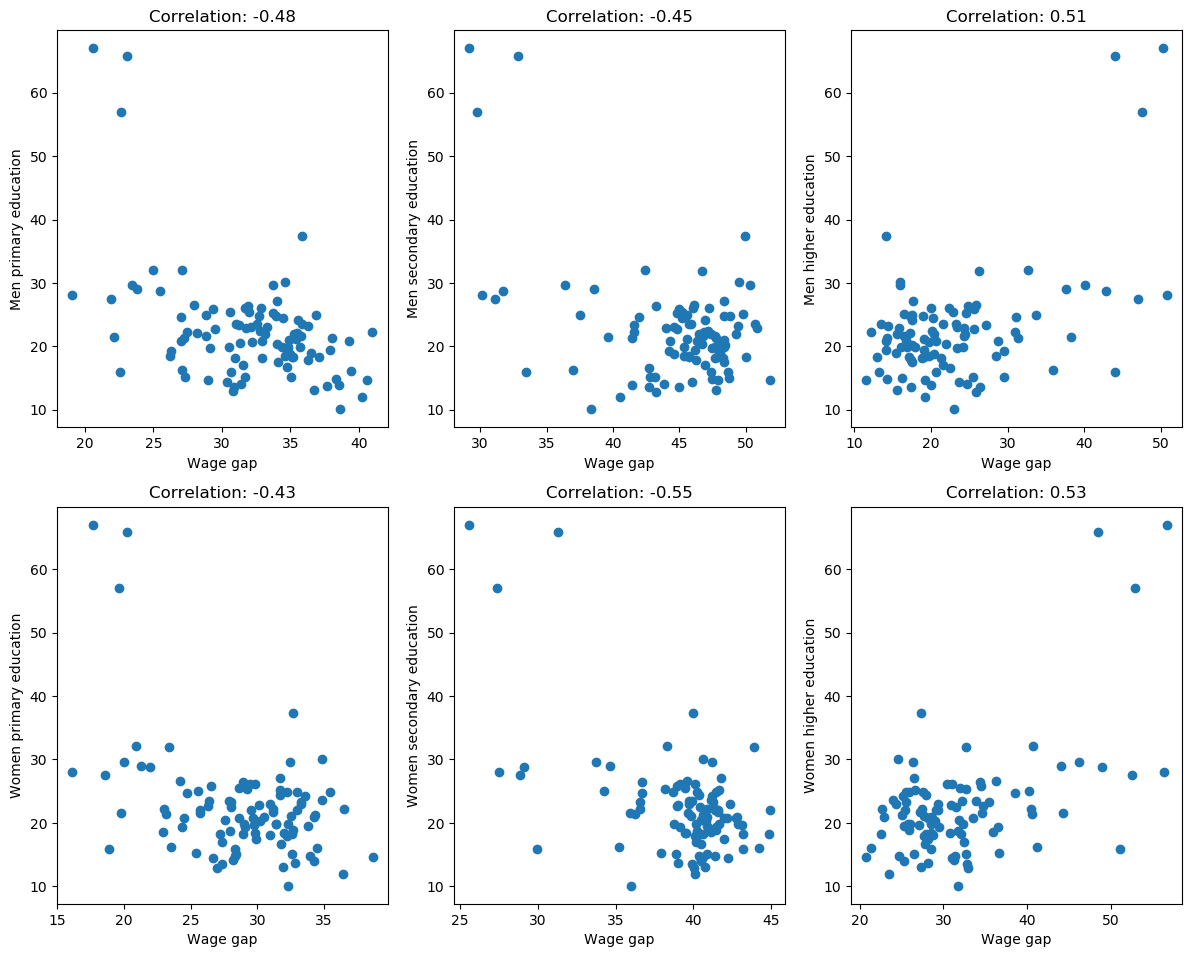

In [24]:
#plotting the different scatterplots using a loop.

#setting up the figure
fig = plt.figure(dpi=100)
Wage = Data_total['Wage']
gs=fig.add_gridspec(3,3)

#starting the loop - creating 6 scatterplots
for i in range(1,7):
    
    ax = fig.add_subplot(3,3,i)
    
    if i==1:
        text='Men primary education'
        data = Data_total[text]
    elif i==2:
        text='Men secondary education'
        data = Data_total[text]
    elif i==3:
        text='Men higher education'
        data = Data_total[text]
    elif i==4:
        text='Women primary education'
        data = Data_total[text]
    elif i==5:
        text='Women secondary education'
        data = Data_total[text]
    else:
        text='Women higher education'
        data = Data_total[text]
        
    leisure1 = np.linspace(0,10,98)

    #calculating the correlation between educational level and wage gap
    korr = np.corrcoef(Wage,data)[1,0]
    korr = "{0:.2f}".format(korr)
    
#Plotting the data 
    ax.scatter(data, Wage)
    ax.set_xlabel("Wage gap")
    ax.set_ylabel(text)
    ax.title.set_text('Correlation: ' + str(korr))
    plt.subplots_adjust(top=3.5,right=2)



## 4.2 Conclusion
Looking at the six scatterplots above, there does not seeme to be any strong correlation between educational level and the wage gap. The correlation coefficient has different signs, but the same magnitude for all six scatterplots. The sign is most likely due to the three outliers, which are present in every plot. In conclusion, adding educational levels as an explanation, did not give us the answer we were looking for. We therefor reach the somewhat unconclusive conclusion, that we cannot explain the wage gap between men and women across municipalities in Denmark. Further analysis could look into different sectors or number of years of work experience between men and women. 